# Linear Regression with Gradient Descent

This notebook demonstrates how to implement linear regression using gradient descent. We begin by loading and preprocessing the data, followed by defining the gradient descent algorithm, training the model, and visualizing the learning process. All steps are performed using Python and NumPy, with minimal use of libraries beyond data handling and plotting.

In [2]:
# --- Library Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

#display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

#suppress convergencewarning for cleaner output
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Data Loading and Preprocessing
We begin by importing the dataset and preparing it for modeling. This includes separating predictors and response variables, followed by min-max normalization of the predictors.

In [4]:
data1 = pd.read_csv("data1.csv") #uses pandas to read the csv data file into a dataframe named data1
X = data1[["X1", "X2", "X3", "X4"]] #separates the predictor variables (first four columns) from the data, this is a dataframe
Y = data1["Y"] #separates the response variable from the data, also used single brackets to make it a series, may need to revisit this
scale = MinMaxScaler() #minmax scaler from scikit learn
X_prime = scale.fit_transform(X) #applies min-max scale to predictor variables: (x-min(x))/(max(x)-min(x))
X_prime_df = pd.DataFrame(X_prime, columns=X.columns) #puts the scaled predictor variables into a dataframe

## Generating All Predictor Subsets Automatically

To ensure flexibility and reduce the risk of manual errors, we use Python’s `itertools.combinations` to automatically generate all non-empty subsets of the available predictor variables. This approach makes it easy to adapt the analysis if additional predictors are added in the future.

In [6]:
from itertools import combinations

predictor_names = ['X1', 'X2', 'X3', 'X4']

#generate all non-empty subsets
predictor_subsets = [
    list(combo)
    for r in range(1, len(predictor_names) + 1)
    for combo in combinations(predictor_names, r)
]

## Cross-Validation Setup and Hyperparameter Configuration

In this section, we define the data splits for 5-fold cross-validation as specified in the assignment. All training hyperparameters—including the learning rate, maximum epochs, and early stopping condition—are collected into a single configuration dictionary for clarity and ease of use. Additional dictionaries are prepared for storing results and model objects across folds. Finally, a random seed is set for reproducibility, ensuring that results remain consistent across runs.


In [8]:
#cross-validation fold definitions (from assignment instructions)
folds = { 
    "fold_1": {"train": list(range(0, 210)), "val": list(range(210, 280)), "test": list(range(280, 400))}, 
    "fold_2": {"train": list(range(70, 280)), "val": list(range(210, 350)), "test": list(range(0, 70))}, 
    "fold_3": {"train": list(range(140, 350)), "val": list(range(0, 70)), "test": list(range(70, 210))},
    "fold_4": {"train": list(range(210, 400)), "val": list(range(0, 140)), "test": list(range(140, 210))},
    "fold_5": {"train": list(range(0, 280)), "val": list(range(280, 350)), "test": list(range(350, 400))}
}

#model and training hyperparameters
config = {
    'learning_rate': 0.01,  #step size for gradient descent
    'max_epochs': 1000,   #maximum number of training epochs
    'early_stopping_patience': 10  #stop if cost doesn't improve for 10 epochs
}

#results and object storage
results = {}   #to store validation MSE and test MSE for each model/fold
results2 = {}   #for various additional MSE measures if needed
model_objects = {}  #to store trained model objects for each fold

## Model Training and Evaluation Loop

This section implements the core training procedure for all linear regression models and predictor subsets using stochastic gradient descent (SGD) with early stopping. For each combination of predictors and cross-validation fold, the model is trained one epoch at a time, and performance is tracked on the training, validation, and test sets. Early stopping is applied if the validation MSE does not improve for a specified number of consecutive epochs. All results, including per-epoch losses and final test set MSE, are stored for further analysis.

In [10]:
for i, subset in enumerate(predictor_subsets, start=1):  
    #this loop will run through each of the predictor column names defined above using the enumerate function to start at 1
    results[f'lm_{i}'] = {}  #creates a dictionary to store test MSE for each model, f-string to reference variable linear model_i (i =1,...,15)
    results2[f'lm_{i}'] = {} #this will be used to store training mse, validation mse, and test mse for each epoch to use for deliverable 2
    model_objects[f'lm_{i}'] = {} #used for storing model objects for each model

    for fold_name, indices in folds.items():  
        #this loop will run through the folds defined above for each model
        num_rows = X_prime_df.shape[0]  
        #this will be able to adjust from using 350 observations to the 400 observations in the test set, .shape returns (rows, columns) and indexing with 0 grabs number of rows
        X_train = X_prime_df.iloc[[j for j in indices["train"] if j < num_rows]][subset]  
        #iloc grabs rows in X_prime_df for "train" in the fold which is less than num_rows for the specified subset 
        X_val = X_prime_df.iloc[[j for j in indices["val"] if j < num_rows]][subset]  
        #iloc grabs rows in X_prime_df for "val" in the fold which is less than num_rows for the specified subset 
        X_test =  X_prime_df.iloc[[j for j in indices["test"] if j < num_rows]][subset]  
        #iloc grabs rows in X_prime_df for "test" in the fold which is less than num_rows for the specified subset 
        Y_train = Y.iloc[[j for j in indices["train"] if j < num_rows]]  
        #iloc grabs rows in Y for "train" in the fold which is less than num_rows
        Y_val = Y.iloc[[j for j in indices["val"] if j < num_rows]]  
        #iloc grabs rows in Y for "val" in the fold which is less than num_rows
        Y_test =  Y.iloc[[j for j in indices["test"] if j < num_rows]]  
        #iloc grabs rows in Y for "test" in the fold which is less than num_rows

        #skip this fold if any of the train, validation, or test splits are empty
        #this can occur if the fold indices exceed the available number of rows in the dataset
        if X_train.empty or X_val.empty or X_test.empty or Y_train.empty or Y_val.empty or Y_test.empty:
            print(f"Skipping Model {i} - {fold_name}: Empty split detected.")
            continue
        
        model = SGDRegressor(
            learning_rate='constant', 
            eta0=config['learning_rate'], 
            #uses SGDRegressor to create a model with arguments learning_rate set at 'constant', eta0=learning_rate starts it at .01
            max_iter=1, 
            warm_start=True   #max_iter makes the model train 1 epoch at a time, warm_start=True lets the model continue training from the previous state
        )

        best_val_mse = float('inf')  #initializes the lowest validation MSE to infinity and is adjusted as the model improves
        no_improvement_count = 0  #tracks how many epochs the validation error fails to improve for the early stopping condition

        results2[f'lm_{i}'][fold_name] = {
            'train_mse': [],
            'val_mse': [],
            'test_mse': []
        }  #initializes list of items to be stored for each epoch 

        for epoch in range(config['max_epochs']): 
            #this loop creates the models 1 epoch at a time with a max of 1000 epochs and checking for the early/second stopping condition
            model.fit(X_train, Y_train)  #creates model using training data for 1 epoch at a time
            Y_train_pred = model.predict(X_train)  #creates prediction data using training data
            train_mse = mean_squared_error(Y_train, Y_train_pred)   #MSE for training data
            Y_val_pred = model.predict(X_val)   #creates prediction data using validation data
            val_mse = mean_squared_error(Y_val, Y_val_pred)  #MSE for validation data
            Y_test_pred_1 = model.predict(X_test)         #creates prediction data using test data 
            test_mse_1 = mean_squared_error(Y_test, Y_test_pred_1)  #per epoch MSE for test data

            results2[f'lm_{i}'][fold_name]['train_mse'].append(train_mse)  #appends train_mse for current epoch to results2
            results2[f'lm_{i}'][fold_name]['val_mse'].append(val_mse)  #appends val_mse for current epoch to results2
            results2[f'lm_{i}'][fold_name]['test_mse'].append(test_mse_1)  #appends test_mse for current epoch to results2
            model_objects[f'lm_{i}'][fold_name] = model

            if val_mse < best_val_mse:  #this will check for the early stopping condition: checks to see if calculated mse < best_val_mse
                best_val_mse = val_mse  #sets current best mse at previous calculated mse if < condition confirmed
                no_improvement_count = 0   #sets improvement counter to 0 because it just changed
            else:      #if < condition doesn't pass
                no_improvement_count += 1  #improvement counter increased by 1
            if no_improvement_count >= config['early_stopping_patience']:  
                #checks to see if improvement counter >= the early/second stopping condition
                print(f"Early stopping at epoch {epoch+1} for Model {i} in {fold_name}")  #prints early stopping message with epoch number of early stopping for which model and fold
                break #breaks out of loop

        Y_test_pred = model.predict(X_test)  #creates prediction data using test data 
        test_mse = mean_squared_error(Y_test, Y_test_pred)  #final MSE for test data
        results[f'lm_{i}'][fold_name] = {'test_mse': test_mse}  #stores test mse results for current model and fold in the results dictionary as another dictionary
        print(f"Model {i} - {fold_name} - Test MSE: {test_mse:.4f}")  #prints model number, fold, and test MSE floating point number with 4 decimal places, used to manually check average test mse

Early stopping at epoch 31 for Model 1 in fold_1
Model 1 - fold_1 - Test MSE: 156.3075
Early stopping at epoch 29 for Model 1 in fold_2
Model 1 - fold_2 - Test MSE: 162.7384
Early stopping at epoch 40 for Model 1 in fold_3
Model 1 - fold_3 - Test MSE: 166.5529
Early stopping at epoch 48 for Model 1 in fold_4
Model 1 - fold_4 - Test MSE: 153.3412
Skipping Model 1 - fold_5: Empty split detected.
Early stopping at epoch 44 for Model 2 in fold_1
Model 2 - fold_1 - Test MSE: 91.5424
Early stopping at epoch 45 for Model 2 in fold_2
Model 2 - fold_2 - Test MSE: 85.9192
Early stopping at epoch 48 for Model 2 in fold_3
Model 2 - fold_3 - Test MSE: 89.2576
Early stopping at epoch 62 for Model 2 in fold_4
Model 2 - fold_4 - Test MSE: 71.7437
Skipping Model 2 - fold_5: Empty split detected.
Early stopping at epoch 18 for Model 3 in fold_1
Model 3 - fold_1 - Test MSE: 165.7289
Early stopping at epoch 48 for Model 3 in fold_2
Model 3 - fold_2 - Test MSE: 180.7857
Early stopping at epoch 15 for Model

## Selecting the Top Models by Average Test MSE

After training all models across every predictor subset and fold, we identify the top five models based on the lowest average test set mean squared error (MSE). This provides a concise summary of the best-performing linear regression configurations, enabling focused comparison and further analysis.


In [12]:
average_test_mse = {} #dictionary for average test MSE for each model

for model_key, folds_data in results.items(): #this will loop over each model in the results dictionary above which contained the keys (e.g. lm_1) and the value for each key which contained fold info
    mse_values = [fold_data['test_mse'] for fold_data in folds_data.values()] #collects test MSE for each fold for the model
    average_test_mse[model_key] = np.mean(mse_values) #calculate the mean test MSE over the five folds for the model and places in dictionary

sorted_models = sorted(average_test_mse.items(), key=lambda x: x[1]) #turns average_test_MSE dictionary into tuples of (model,avg_test_MSE) and then sorts based on avg_test_MSE, stores in sorted_models
best_five = sorted_models[:5] #gets the best five models ('best' means lowest average test MSE)
print("Best Five Models based on Average Test MSE:")
for model, avg_mse in best_five:
    print(f"{model}: Average Test MSE is {avg_mse:.2f}") #f-string to use variables from best_five, model and avg_mse (floating point number rounded to two places)

Best Five Models based on Average Test MSE:
lm_15: Average Test MSE is 68.16
lm_12: Average Test MSE is 69.47
lm_11: Average Test MSE is 75.58
lm_9: Average Test MSE is 76.84
lm_14: Average Test MSE is 76.93


## Plotting MSE Curves for the Top Models

For each of the five best models (as determined by average test MSE), we plot the training, validation, and test MSE across epochs for all folds. These plots provide a detailed view of the learning dynamics and help identify trends such as convergence behavior, overfitting, and generalization performance.

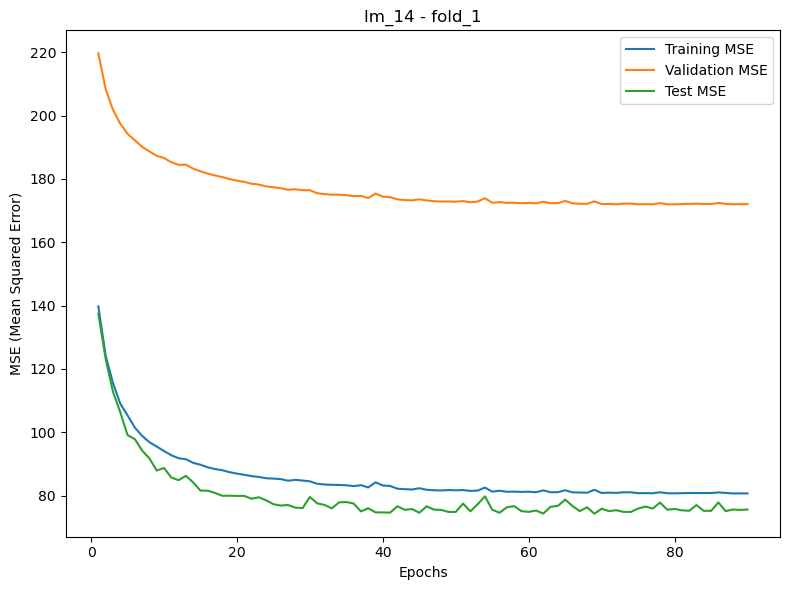

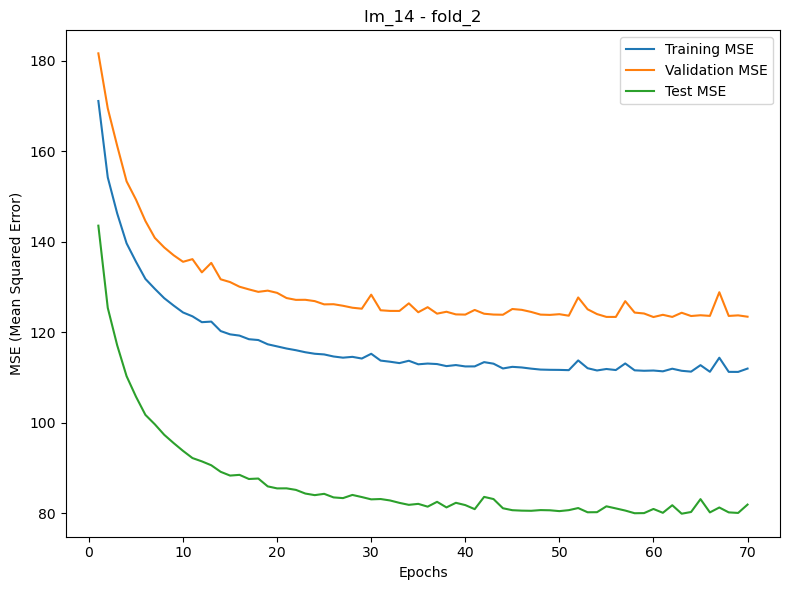

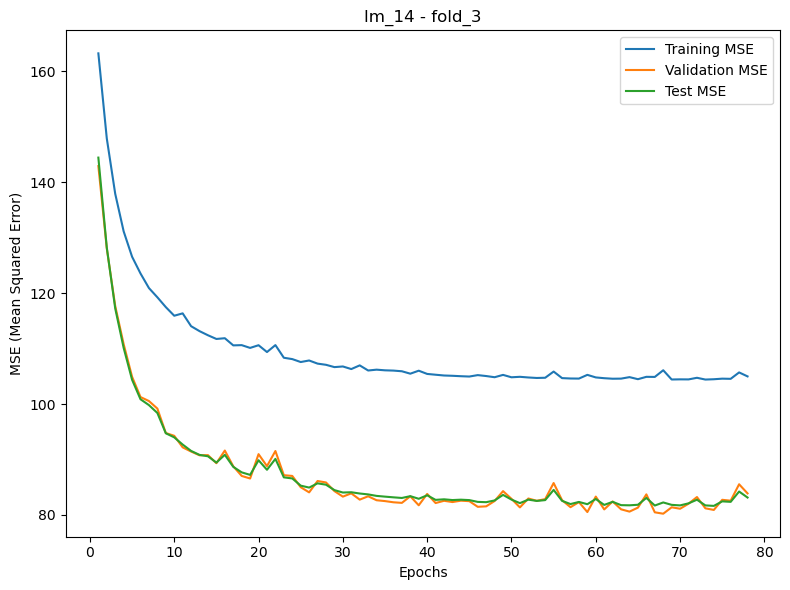

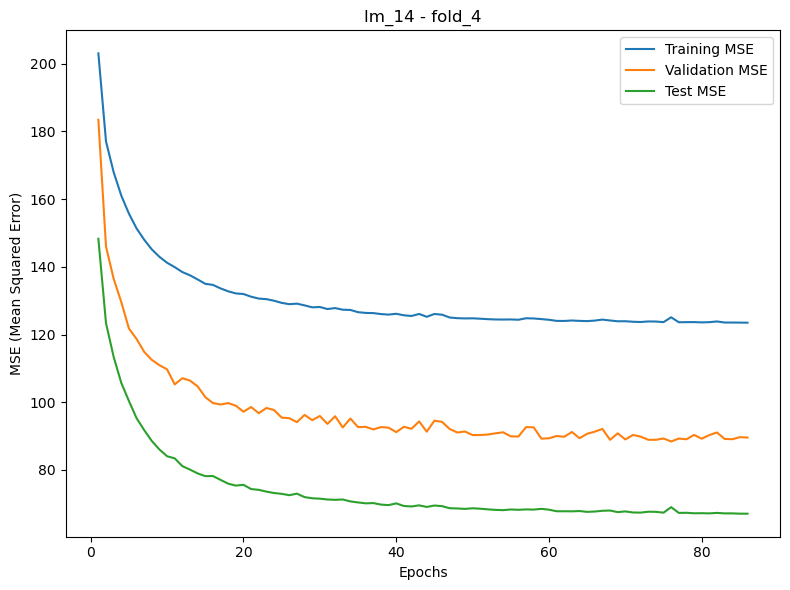

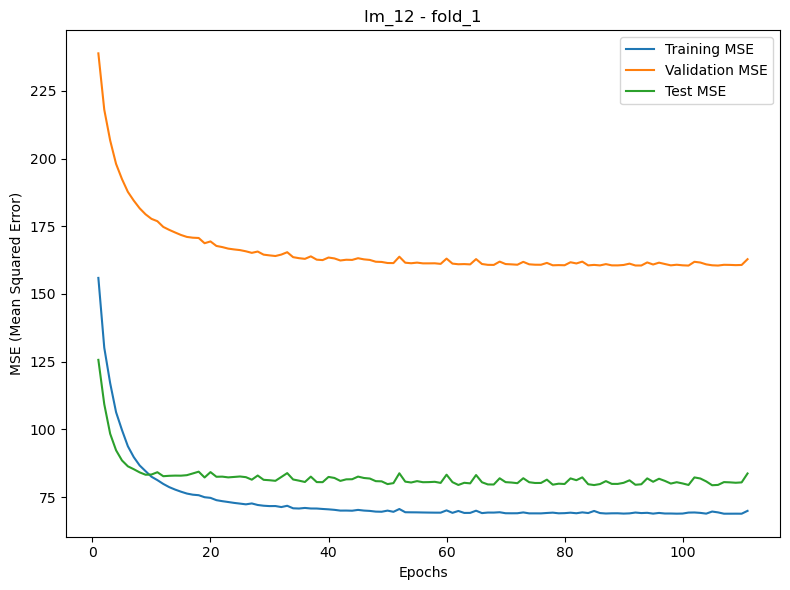

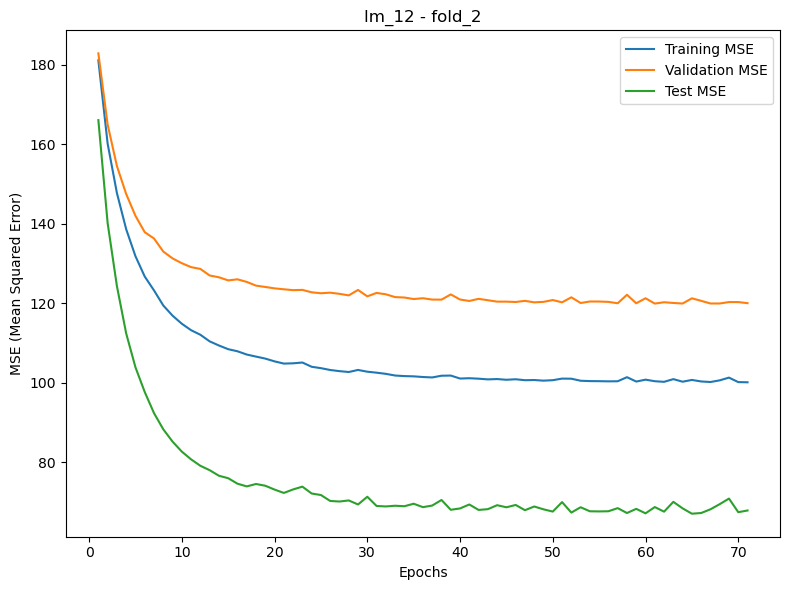

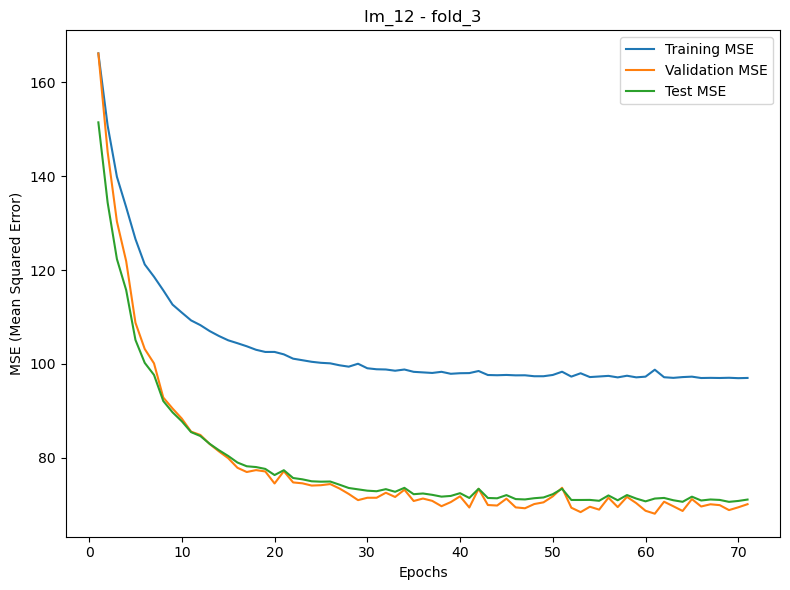

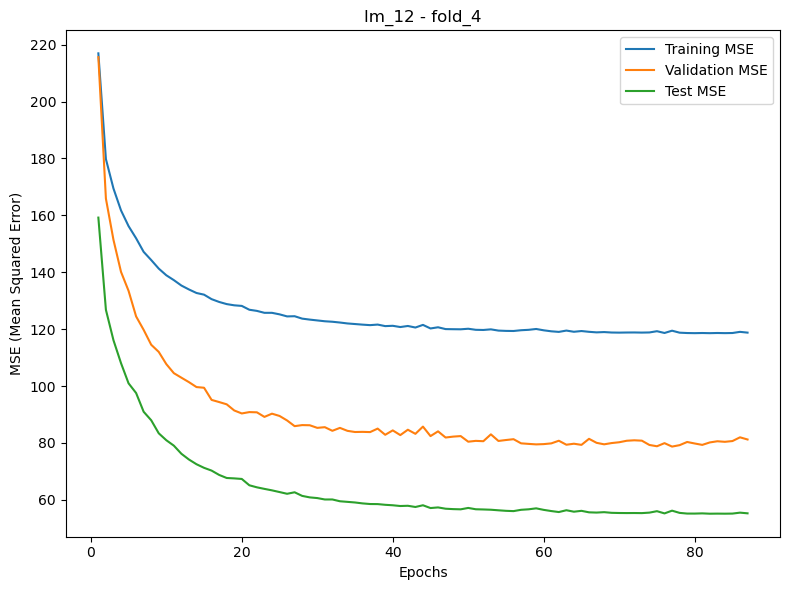

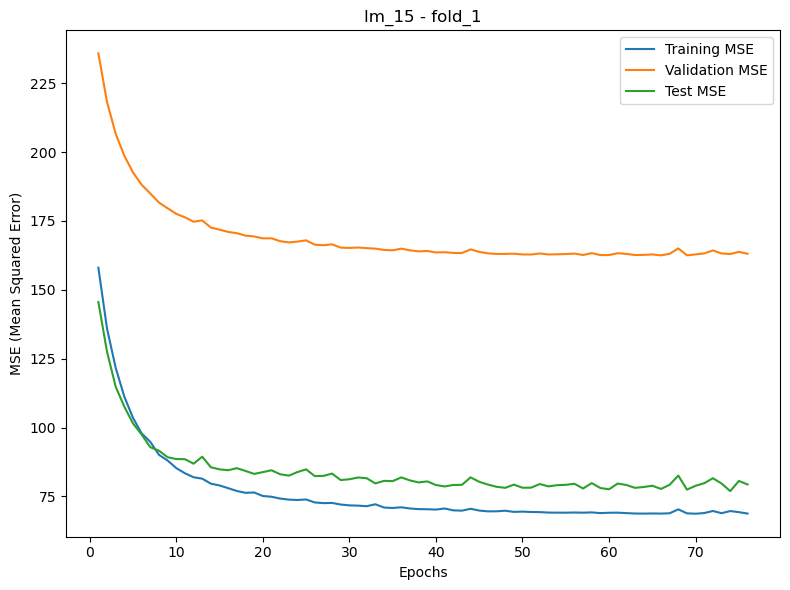

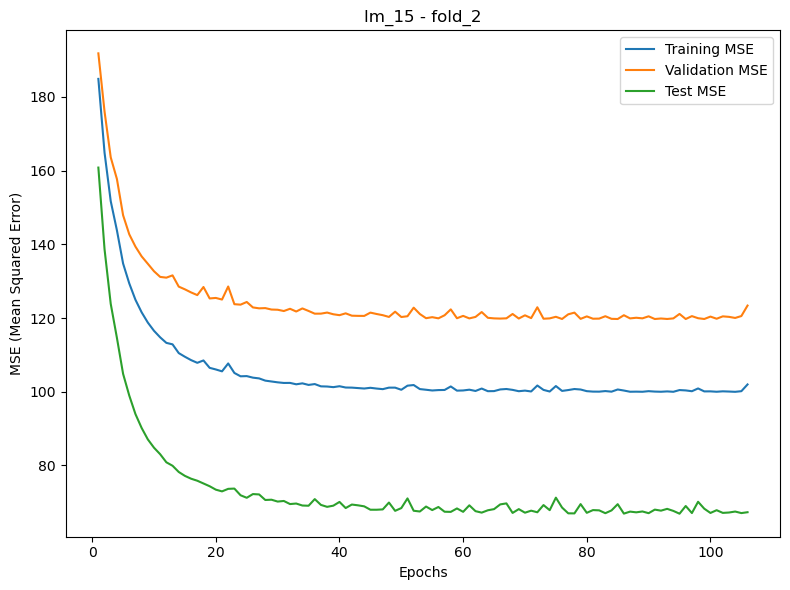

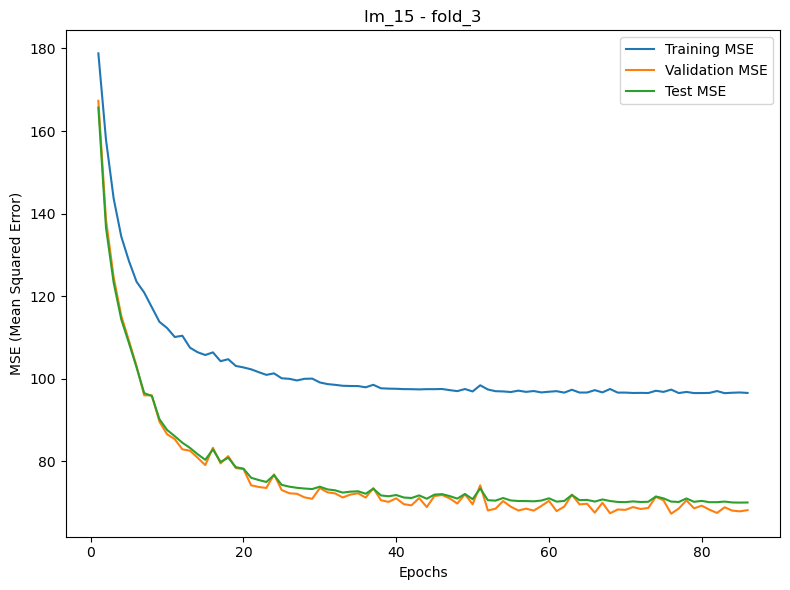

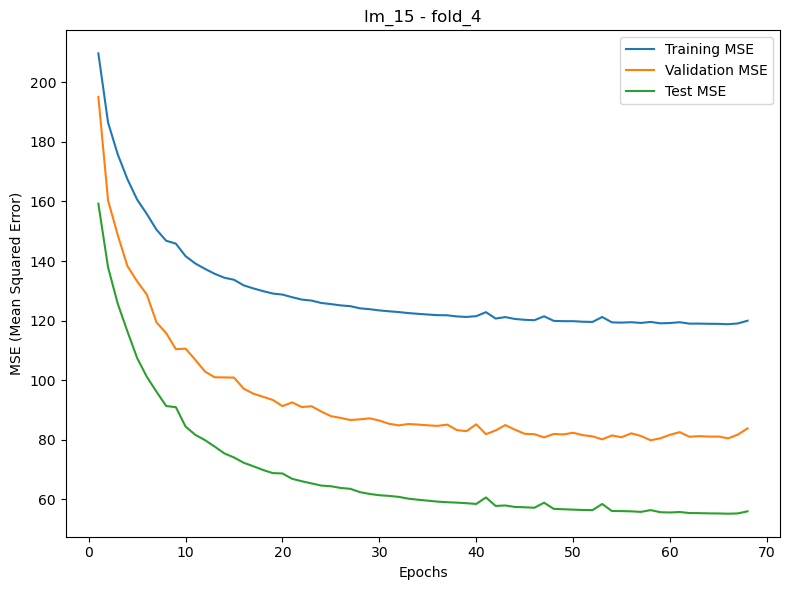

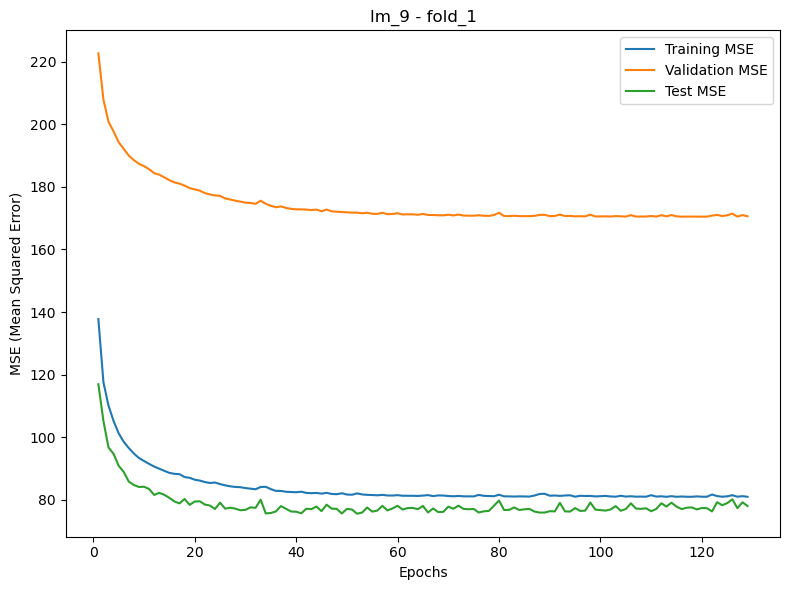

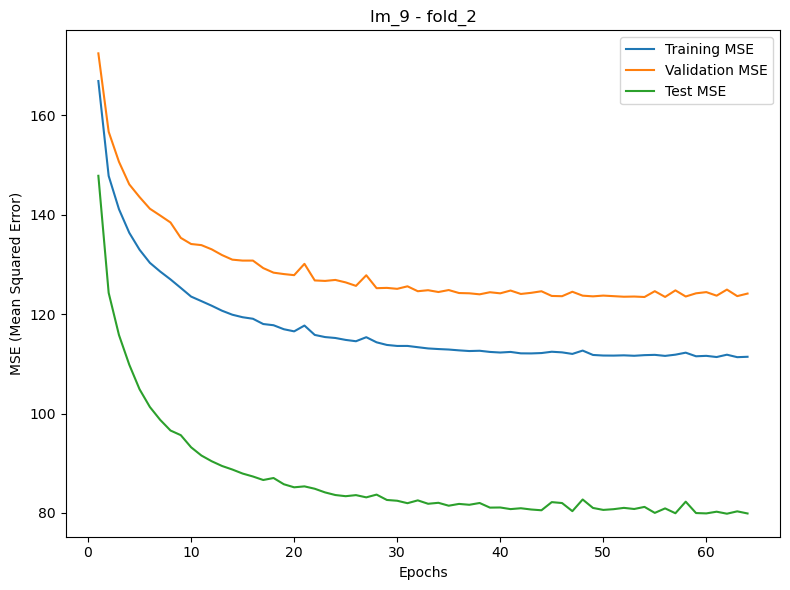

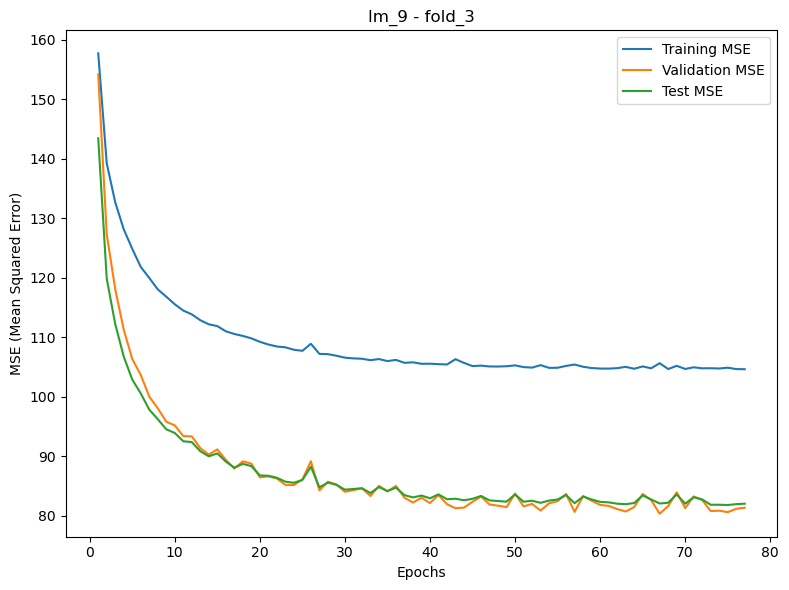

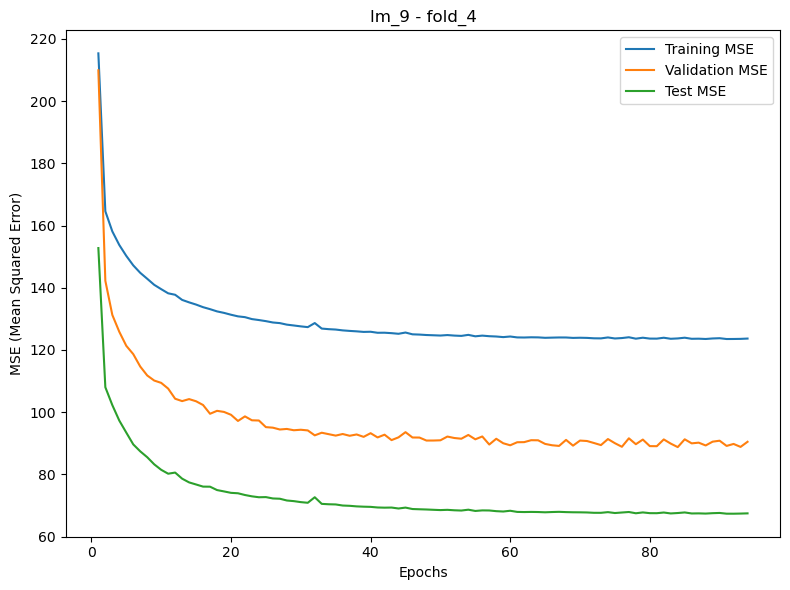

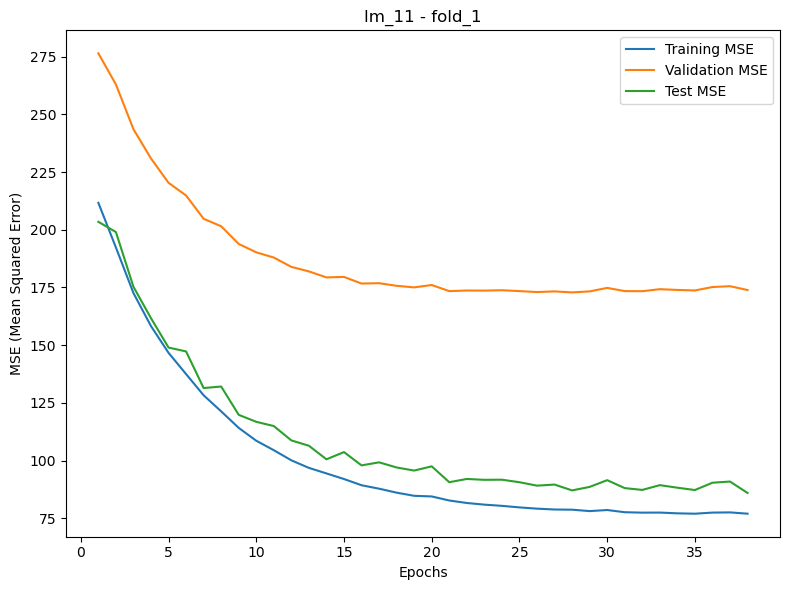

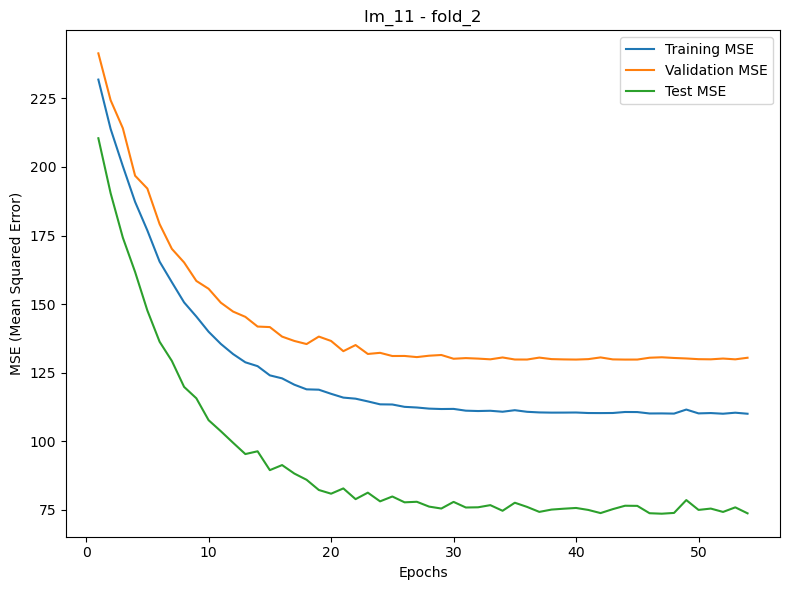

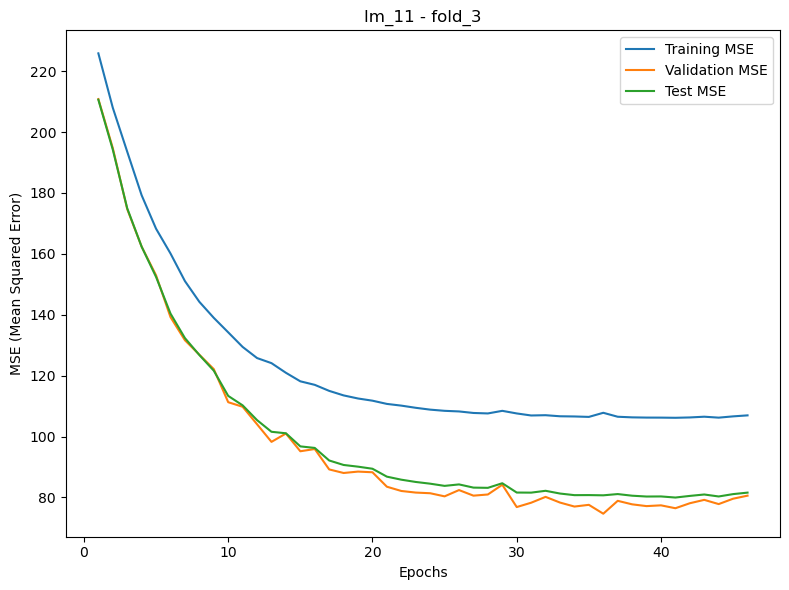

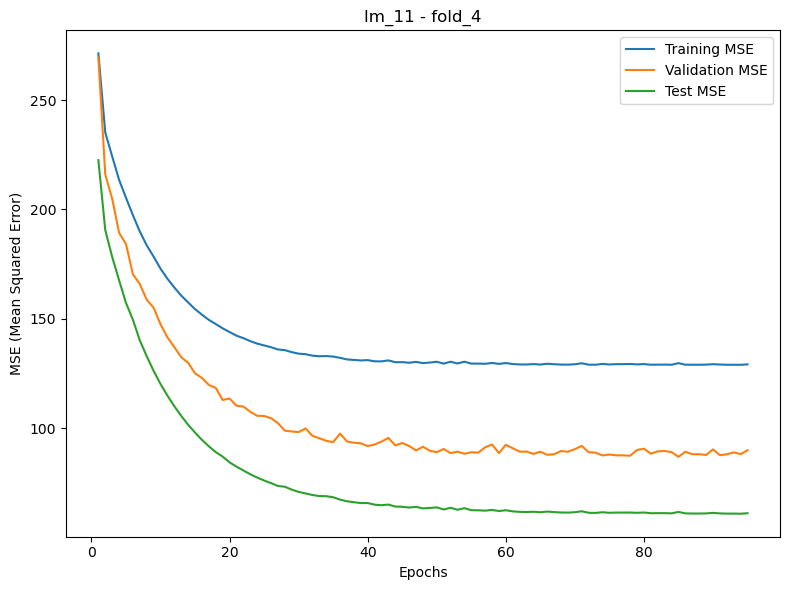

In [14]:
best_models = {model for model, mse in best_five} #using best_five from previous cell which contains tuples of the five best models and average test mse
for model_key in best_models: #this loop will run through each best model and the five folds to create plots
    for fold_name, metrics in results2[model_key].items(): 
        epochs = range(1, len(metrics['train_mse']) + 1) #this uses the length of 'train_mse' as the number of epochs, range goes from 1 to that length
        plt.figure(figsize=(8,6)) #sets canvas for plots at 8 in x 6 in
        plt.plot(epochs, metrics['train_mse'], label='Training MSE') #plots training mse line
        plt.plot(epochs, metrics['val_mse'], label='Validation MSE') #plots validation mse line
        plt.plot(epochs, metrics['test_mse'], label='Test MSE') #plots test mse line
        plt.xlabel('Epochs') #x axis label
        plt.ylabel('MSE (Mean Squared Error)') #y axis label
        plt.title(f"{model_key} - {fold_name}") #title showing model number dash fold 
        plt.legend() #shows the legend in the plot
        plt.tight_layout() #prevents overlapping or cutoff of labels in plots
        plt.show() #display the plot

## Conclusion
In this notebook, we built a linear regression model using gradient descent. We preprocessed the data, implemented the algorithm, and observed the learning curve. This hands-on approach demonstrates the inner workings of gradient descent and highlights its power for training simple models. For more complex datasets, additional feature engineering and regularization may be necessary, but the core concepts remain the same.